<div>
<img src="https://www.automation.com/getmedia/3c46e651-52ef-4d7e-9ee1-4e2132173f57/EUS031---Image" width="250" align="left"/>
</div>

## Reinforcement Learning Final Project: Inventory Management
Group 6: Michael, Annie, Targoon

### Necessary imports

In [26]:
import os
from os.path import basename
import sys
import platform

import gym
from gym import spaces
from gym import utils
from gym.utils import seeding

import pandas as pd
import numpy as np
import quantecon as qe


from collections import Counter
from itertools import groupby

import warnings
warnings.filterwarnings("ignore") # supress warnings

import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_row', 20) # set max row display
pd.set_option('display.max_columns', 20) # set max column width

import logging
logger = logging.getLogger(__name__)

# enable ability to see the value of multiple statements at once
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [19]:
%pwd

'/Users/colella2/Google Drive/Graduate School/MScA/Courses/Reinforcement Learning/final_project/gym_inventory/envs'

In [20]:
# check python version
from platform import python_version
print(python_version())

3.7.8


### Instantiate class from gym environment

In [21]:
class InventoryEnv(gym.Env, utils.EzPickle):
    """Inventory control with lost sales environment

    TO BE EDITED

    This environment corresponds to the version of the inventory control
    with lost sales problem described in Example 1.1 in Algorithms for
    Reinforcement Learning by Csaba Szepesvari (2010).
    https://sites.ualberta.ca/~szepesva/RLBook.html
    """

    def __init__(self, n=10, k=5, c=2, h=2, p=3, lam=5): # default values
        self.n = n 
        self.action_space = spaces.Discrete(n)
        self.observation_space = spaces.Discrete(n)
        self.max = n # have to optimize max items held at certain
        self.state = n
        self.k = k # fixed entry cost for ordering; k must be greater than 0
        self.c = c # fixed price of purchase for items
        self.h = h # proportionality value must be greater than 0; cost per unit; constant that we multiply by remaining inventory
        self.p = p # p is price and must be greater than 0
        self.lam = lam
        
        # we do not know what demand will be 
        # upon selling z units the manager is paid the monetary amount of p z, where p > 0.

        # Set seed
        self._seed()

        # Start the first round
        self._reset()

    def demand(self):
        return np.random.poisson(self.lam) # randomly generated demand based on poisson distribution

    # transition probabilities
    def transition(self, x, a, d): # action At gives the number of items ordered in the evening of day t
        # x is initial state
        
        m = self.max
        
        # size of next inventory is xt+1
        return max(min(x + a, m) - d, 0) # subtract the d (demand) that you will recieve the next day

    def reward(self, x, a, y):
        k = self.k
        m = self.max # m is equal to n
        c = self.c
        h = self.h
        p = self.p
        r = -k * (a > 0) - c * max(min(x + a, m) - x, 0) - h * x + p * max(min(x + a, m) - y, 0)
        return r

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _step(self, action):
        assert self.action_space.contains(action)
        obs = self.state
        demand = self.demand()
        obs2 = self.transition(obs, action, demand)
        self.state = obs2
        reward = self.reward(obs, action, obs2)
        done = 0
        return obs2, reward, done, {}

    def _reset(self):
        return self.state

We are going to start with a smaller sample set.

### Step 1: Transition probability matrix

In [28]:
InventoryEnv().n
InventoryEnv().k
InventoryEnv().h
InventoryEnv().c
InventoryEnv().p
InventoryEnv().lam

10

5

2

2

3

5

In [29]:
env = InventoryEnv()

In [30]:
dir(env)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_reset',
 '_seed',
 '_step',
 'action_space',
 'c',
 'close',
 'demand',
 'h',
 'k',
 'lam',
 'max',
 'metadata',
 'n',
 'np_random',
 'observation_space',
 'p',
 'render',
 'reset',
 'reward',
 'reward_range',
 'seed',
 'spec',
 'state',
 'step',
 'transition',
 'unwrapped']

In [31]:
P_t = np.zeros([env.n + 1, env.n + 1, env.n + 1]) #(x=t, x=t+1, a)
P_t

# 11 x 11 x 11
P_t.shape

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

(11, 11, 11)

In [32]:
RR = np.zeros([env.n + 1, env.n + 1, env.n + 1]) 
RR

# 11 x 11 x 11
RR.shape

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

(11, 11, 11)

In [50]:
#simulate demands 
T = 10000

# action 10, transitioning from state 0 to state x
#range(env.n + 1)

for init_state in range(env.n + 1):
    for action in range(env.n + 1):
        final_state_list = []
        demand_list = []
        
        for i in range(T):
            demand = env.demand()
            final_state = env.transition(init_state, action, demand)
            demand_list.append(demand)
            final_state_list.append(final_state)
            
        final_state_count = Counter(final_state_list)
        
        for (final_state,probability) in final_state_count.items():
            P_t[init_state, final_state, action] = probability / T
            
        for final_state in range(env.n + 1):
            RR[init_state, final_state, action] = env.reward(init_state, action, final_state)

In [51]:
P_t[0, :, 3]

RR[0, :, 3]

array([0.88  , 0.0804, 0.0322, 0.0074, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    ])

array([ -2.,  -5.,  -8., -11., -11., -11., -11., -11., -11., -11., -11.])

In [52]:
np.sum(P_t[10, :, 10])

1.0

In [53]:
k = env.k

k

5

In [54]:
print(k, v/10000)

NameError: name 'v' is not defined

In [55]:
for i/10000 in final_state_count:
    

SyntaxError: unexpected EOF while parsing (<ipython-input-55-fdd484de22db>, line 2)

(array([ 368.,  863., 3152., 1747., 2525.,  675.,  537.,   75.,   53.,
           5.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <a list of 10 Patch objects>)

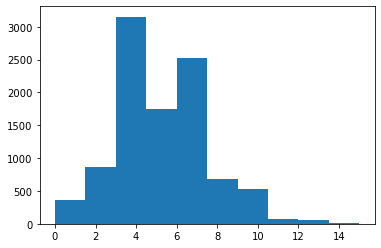

In [56]:
plt.hist(demand_list)

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([ 9.5,  9.6,  9.7,  9.8,  9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5]),
 <a list of 10 Patch objects>)

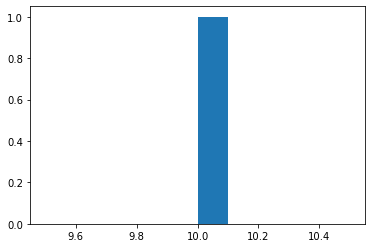

In [57]:
plt.hist(final_state)

In [6]:
# start with m of 10; this is max inventory size
# would then have 10 x 10 matrix



### Step 2:

### Step 3:

### Step 4:

### Step 5: